In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import time
import multiprocessing

In [2]:
def lehmer_prng(seed):
    value = seed
    while True:
        value = (7**5 * value) % (2**31 - 1)
        yield value

def scale_prn(x, maxv):
    return int(maxv * x / 0x7FFFFFFF)

In [3]:
default_n1 = 2
default_seed = 2000

def L(n, k, n1 = default_n1, seed = default_seed):
    prng = lehmer_prng(seed)
    p_tbl = [ p % (n - k) for p in range(k * n1)]
    matrix = [[] for _ in range(n - k)]
    t = 0
    for col in range(k):
        for h in range(n1):
            i = t
            while i < k * n1 and col in matrix[p_tbl[i]]:
                i += 1
            if i >= k * n1:
                while True:
                    row = scale_prn(next(prng), n - k)
                    if col not in matrix[row]:
                        break
                matrix[row].append(col)
            else:
                while True:
                    p = scale_prn(next(prng), k * n1 - t) + t
                    if col not in matrix[p_tbl[p]]:
                        break
                matrix[p_tbl[p]].append(col)
                p_tbl[p] = p_tbl[t]
                t += 1
    for row in range(n - k):
        degree = len(matrix[row])
        if degree == 0:
            col = scale_prn(next(prng), k)
            matrix[row].append(col)
        if degree <= 1:
            while True:
                col = scale_prn(next(prng), k)
                if col not in matrix[row]:
                    break
            matrix[row].append(col)
    return matrix

def identity_scheme(n, k, n1 = default_n1, seed = default_seed):
    matrix = L(n, k, n1, seed)
    for row in range(n-k):
        matrix[row].append(k + row)
    return matrix

def staircase_scheme(n, k, n1 = default_n1, seed = default_seed):
    matrix = L(n, k, n1, seed)
    for row in range(n-k):
        if row != 0:
            matrix[row].append(k + row - 1)
        matrix[row].append(k + row)
    return matrix

def triangle_scheme(n, k, n1 = default_n1, seed = default_seed):
    matrix = L(n, k, n1, seed)
    for row in range(n-k):
        for col in range(k, k+row+1):
            matrix[row].append(col)
    return matrix

def list_to_GF2_matrix(matrix, n, k):
    A = Matrix(GF(2), n-k, n)
    for i, row in enumerate(matrix):
        for j in row:
            A[i,j] = 1
    return A

In [4]:
def erasure_submatrix(matrix, erasures):
    s = set(erasures)
    return [[col for col in row if col in s] for row in matrix]

In [5]:
def is_decodable(matrix, erasures, n, k):
    return list_to_GF2_matrix(erasure_submatrix(matrix, erasures), n, k).rank() == len(erasures)

In [6]:
def is_simple_decodable(matrix, erasures):
    m = erasure_submatrix(matrix, erasures)
    while True:
        if numpy.all([len(row) == 0 for row in m]):
            return True
        try:
            e = next((row[0] for row in m if len(row) == 1))
        except StopIteration:
            return False
        m = [[col for col in row if col != e] for row in m]

In [7]:
def random_erasures(n, p):
    return [j for j in range(n) if numpy.random.binomial(1, p)]

def random_erasures_optimized(n, p):
    erasures = list()
    e = numpy.random.binomial(n, p)
    for _ in range(e):
        while True:
            j = numpy.random.randint(n)
            if j not in erasures:
                erasures.append(j)
                break
    return erasures

In [8]:
def printing_range(n, every = 100000):
    j = 0
    while j < n:
        if not j % every:
            print("{} {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), j))
        yield j
        j += 1
        
def decode_probability(matrix, n, k, erasure_probability, trials = 1000000):
    print('decode_probability p = {}'.format(erasure_probability))
    return sum((is_decodable(matrix, random_erasures_optimized(n, erasure_probability), n, k) for _ in printing_range(trials)))/trials

def simple_decode_probability(matrix, n, k, erasure_probability, trials = 1000000):
    print('simple_decode_probability p = {}'.format(erasure_probability))
    return sum((is_simple_decodable(matrix, random_erasures_optimized(n, erasure_probability)) for _ in printing_range(trials)))/trials

In [9]:
def compute(n, k):
    ps = numpy.logspace(-3,-1,11)
    h = identity_scheme(n,k)
    dp_identity = [decode_probability(h, n, k, p) for p in ps]
    dp_simple_identity = [simple_decode_probability(h, n, k, p) for p in ps]
    h = staircase_scheme(n,k)
    dp_staircase = [decode_probability(h, n, k, p) for p in ps]
    dp_simple_staircase = [simple_decode_probability(h, n, k, p) for p in ps]
    h = triangle_scheme(n,k)
    dp_triangle = [decode_probability(h, n, k, p) for p in ps]
    dp_simple_triangle = [simple_decode_probability(h, n, k, p) for p in ps]
    save((dp_identity, dp_simple_identity, dp_staircase, dp_simple_staircase, dp_triangle, dp_simple_triangle), '{}_{}'.format(n,k))

The calculations below take many hours to run. The results are saved in some files. Uncomment them to rerun the calculations and regenerate these files.

In [10]:
# compute(n = 600, k = 500)

In [11]:
# compute(n = 1000, k = 833)

In [14]:
def make_plot(n, k):
    ps = numpy.logspace(-3,-1,11)
    dp_identity, dp_simple_identity, dp_staircase, dp_simple_staircase, dp_triangle, dp_simple_triangle = load('{}_{}'.format(n,k))
    plt.loglog(ps, [1-p for p in dp_identity], 'b-', alpha=0.5, label = 'Identity')
    plt.loglog(ps, [1-p for p in dp_simple_identity], 'b--', label = 'Identity (iterative)')
    plt.loglog(ps, [1-p for p in dp_staircase], 'g-', alpha=0.5, label = 'Staircase')
    plt.loglog(ps, [1-p for p in dp_simple_staircase], 'g--', label = 'Staircase (iterative)')
    plt.loglog(ps, [1-p for p in dp_triangle], 'r-', alpha=0.5, label = 'Triangle')
    plt.loglog(ps, [1-p for p in dp_simple_triangle], 'r--', label = 'Triangle (iterative)')
    plt.xlabel('Erasure rate')
    plt.ylabel('Codeword error rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('LDPC codeword error rate (n = {}, k = {})'.format(n,k));

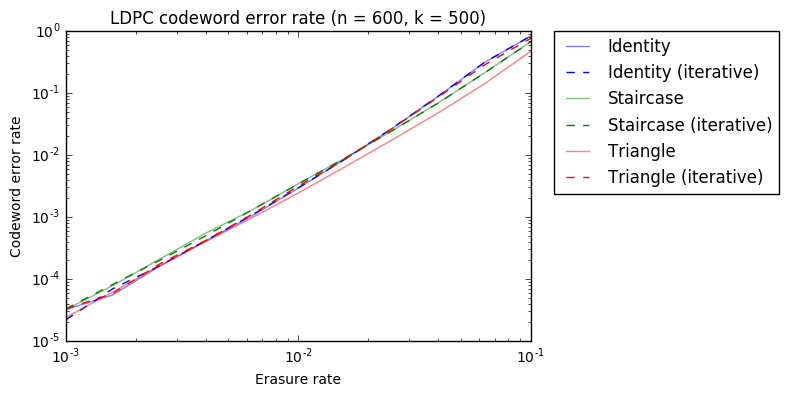

In [15]:
make_plot(n = 600, k = 500)

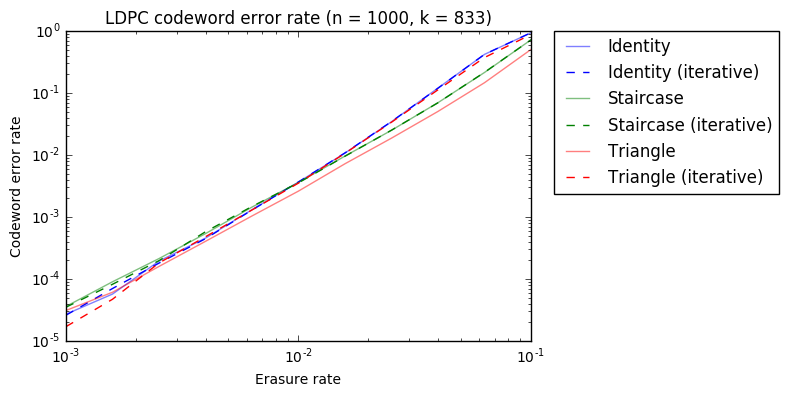

In [16]:
make_plot(n = 1000, k = 833)